In [1]:
# For handling data and JSON files
import json
import numpy as np
import os

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# For building and training a neural network
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
import json
import numpy as np
import os

# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # Assuming 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            # Extract x, y coordinates only
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints, 
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)
    
    return np.array(X), np.array(y)


# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)


              precision    recall  f1-score   support

           0       0.88      0.93      0.91       458
           1       0.88      0.88      0.88       396
           2       0.93      0.93      0.93       345
           3       0.91      0.89      0.90       424
           4       0.96      0.98      0.97       406
           5       0.94      0.92      0.93       445
           6       0.94      0.94      0.94       504
           7       0.87      0.81      0.84       259
           8       0.89      0.90      0.90       296

    accuracy                           0.91      3533
   macro avg       0.91      0.91      0.91      3533
weighted avg       0.91      0.91      0.91      3533



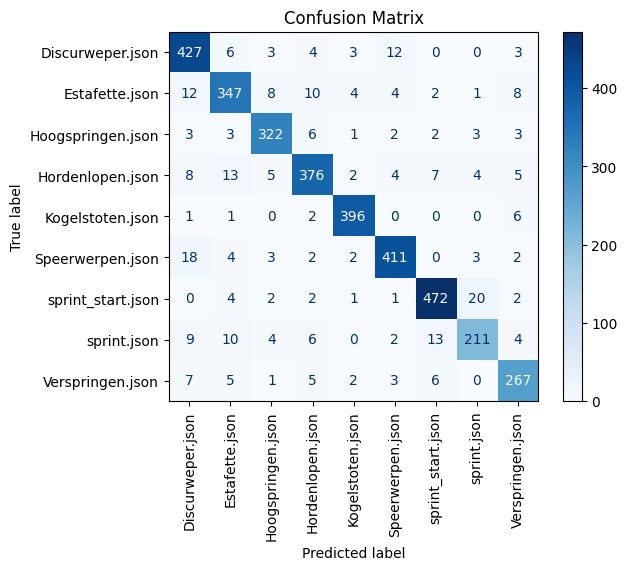

In [10]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the scaler
scaler = MinMaxScaler()

# Split data into training and testing sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(exercise_labels.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# Reverse mapping of exercise labels
exercise_labels_inv = {v: k for k, v in exercise_labels.items()}


In [12]:
def extract_keypoints_and_predict(frame, model, clf, scaler):
    # Run the YOLO pose model
    results = model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        return None, None  # Skip if no keypoints detected
    
    # Initialize variables to store the keypoints of the largest person
    largest_area = 0
    selected_keypoints = None

    for result in results:
        if result.keypoints is not None and result.boxes is not None and len(result.boxes) > 0:
            keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # x, y coordinates
            bbox = result.boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
            x_min, y_min, x_max, y_max = bbox
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            area = bbox_width * bbox_height

            if area > largest_area:
                largest_area = area
                selected_keypoints = keypoints.flatten()

    if selected_keypoints is None:
        return None, None

    # Check if the number of keypoints matches the expected number
    expected_num_features = scaler.n_features_in_
    if selected_keypoints.size != expected_num_features:
        print(f"Expected {expected_num_features} features, but got {selected_keypoints.size} features")
        return None, None

    # Normalize keypoints
    normalized_keypoints = scaler.transform([selected_keypoints])

    # Predict class and probabilities
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Apply softmax to the confidence scores if not already probabilities
    exercise_class_proba = softmax(exercise_class_proba, axis=1)

    return exercise_class[0], exercise_class_proba[0]


In [15]:
# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Hoogspringen/segment_000001.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame, model, clf, scaler)
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue  # Skip problematic frames

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")



0: 384x640 1 person, 130.9ms
Speed: 14.8ms preprocess, 130.9ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 74.3ms
Speed: 0.7ms preprocess, 74.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 74.0ms
Speed: 0.9ms preprocess, 74.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 87.5ms
Speed: 0.8ms preprocess, 87.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 84.7ms
Speed: 0.9ms preprocess, 84.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 85.7ms
Speed: 0.7ms preprocess, 85.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 75.8ms
Speed: 0.7ms preprocess, 75.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 76.2ms
Speed: 0.8ms preprocess, 76.2ms inference, 0.5ms postprocess per image at shape (1, 3

In [16]:
# Output results
print("Class Percentages (Based on Frame Count):")
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

print("\nAverage Probabilities (Softmax Scores):")
for cls, pct in probability_percentages.items():
    print(f"{cls}: {pct:.2f}%")

# Print all classes and their percentages
print("\nAll Classes and Percentages:")
for cls in class_labels:
    if cls in class_percentages:
        print(f"{cls}: {class_percentages[cls]:.2f}%")
    else:
        print(f"{cls}: 0.00%")

Class Percentages (Based on Frame Count):
Hoogspringen.json: 99.14%
Estafette.json: 0.86%

Average Probabilities (Softmax Scores):
Discurweper.json: 9.78%
Estafette.json: 10.04%
Hoogspringen.json: 22.03%
Hordenlopen.json: 10.01%
Kogelstoten.json: 9.56%
Speerwerpen.json: 9.54%
sprint_start.json: 9.75%
sprint.json: 9.70%
Verspringen.json: 9.60%

All Classes and Percentages:
0: 0.00%
1: 0.00%
2: 0.00%
3: 0.00%
4: 0.00%
5: 0.00%
6: 0.00%
7: 0.00%
8: 0.00%


In [8]:
# For handling data and JSON files
import json
import numpy as np
import os

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For data normalization
from sklearn.preprocessing import MinMaxScaler

# For visualization
import matplotlib.pyplot as plt

# For pose detection
from ultralytics import YOLO

# For softmax
from scipy.special import softmax

# For counting classes
from collections import Counter


In [9]:
# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 51:  # 17 keypoints * 3 (x, y, visibility)
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Extract x, y coordinates only and flatten
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)
    
    return np.array(X), np.array(y)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")


Feature matrix shape: (17662, 34)
Labels array shape: (17662,)


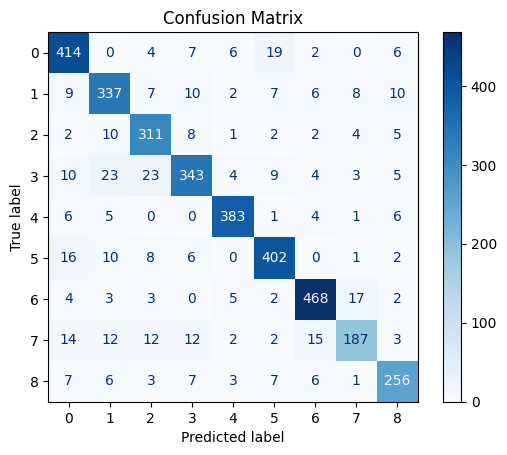

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       458
           1       0.83      0.84      0.84       396
           2       0.84      0.91      0.88       345
           3       0.87      0.82      0.84       424
           4       0.95      0.94      0.94       406
           5       0.89      0.90      0.90       445
           6       0.92      0.93      0.92       504
           7       0.86      0.73      0.79       259
           8       0.86      0.86      0.86       296

    accuracy                           0.88      3533
   macro avg       0.88      0.87      0.87      3533
weighted avg       0.88      0.88      0.88      3533



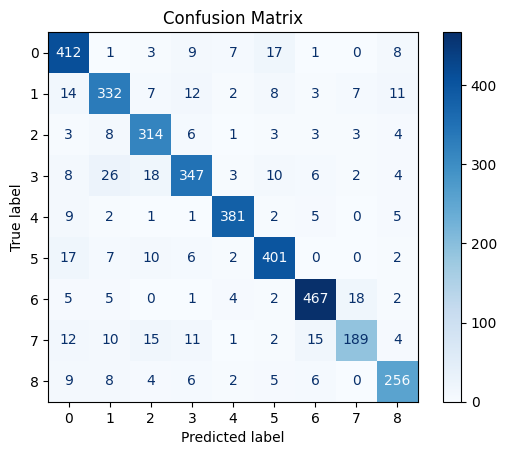


0: 384x640 1 person, 98.8ms
Speed: 1.7ms preprocess, 98.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Predicted exercise class: [2]


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)  # Fit and transform the scaler on the entire dataset

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Function to extract keypoints and predict the exercise
def extract_keypoints_and_predict(image_path, model, clf, scaler):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run the model to extract keypoints
    result = model(image)
    if isinstance(result, list):
        result = result[0]  # Assuming the first element contains the keypoints

    keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # Flatten keypoints

    # Normalize the keypoints
    normalized_keypoints = scaler.transform([keypoints.flatten()])

    # Predict the exercise class using the classifier
    exercise_class = clf.predict(normalized_keypoints)
    print(f"Predicted exercise class: {exercise_class}")

# Path to a new image (test image)
image_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/images/frame_1625.jpg"

# Call the function to extract keypoints and predict the exercise
extract_keypoints_and_predict(image_path, model, clf, scaler)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       458
           1       0.82      0.84      0.83       396
           2       0.84      0.90      0.87       345
           3       0.86      0.83      0.85       424
           4       0.94      0.94      0.94       406
           5       0.88      0.90      0.89       445
           6       0.92      0.94      0.93       504
           7       0.88      0.72      0.79       259
           8       0.87      0.86      0.86       296

    accuracy                           0.88      3533
   macro avg       0.87      0.87      0.87      3533
weighted avg       0.88      0.88      0.88      3533



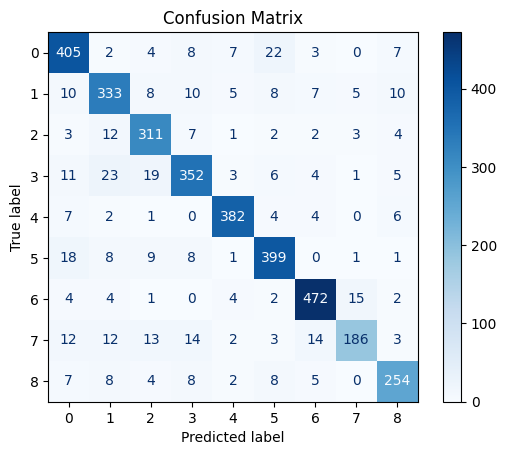


0: 384x640 1 person, 95.9ms
Speed: 2.9ms preprocess, 95.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Predicted exercise class: [2]
Confidence scores: [[       0.09         0.1        0.35        0.05        0.01         0.2        0.06        0.02        0.12]]


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)  # Fit and transform the scaler on the entire dataset

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Function to extract keypoints and predict the exercise with confidence scores
def extract_keypoints_and_predict(image_path, model, clf, scaler):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run the model to extract keypoints
    result = model(image)
    if isinstance(result, list):
        result = result[0]  # Assuming the first element contains the keypoints

    keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # Flatten keypoints

    # Normalize the keypoints
    normalized_keypoints = scaler.transform([keypoints.flatten()])

    # Predict the exercise class using the classifier
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Print the predicted class and confidence scores
    print(f"Predicted exercise class: {exercise_class}")
    print(f"Confidence scores: {exercise_class_proba}")

# Path to a new image (test image)
image_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/images/frame_1625.jpg"

# Call the function to extract keypoints and predict the exercise
extract_keypoints_and_predict(image_path, model, clf, scaler)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       458
           1       0.83      0.85      0.84       396
           2       0.85      0.90      0.87       345
           3       0.86      0.82      0.84       424
           4       0.94      0.94      0.94       406
           5       0.90      0.89      0.89       445
           6       0.91      0.93      0.92       504
           7       0.88      0.71      0.79       259
           8       0.86      0.87      0.87       296

    accuracy                           0.88      3533
   macro avg       0.87      0.87      0.87      3533
weighted avg       0.88      0.88      0.88      3533



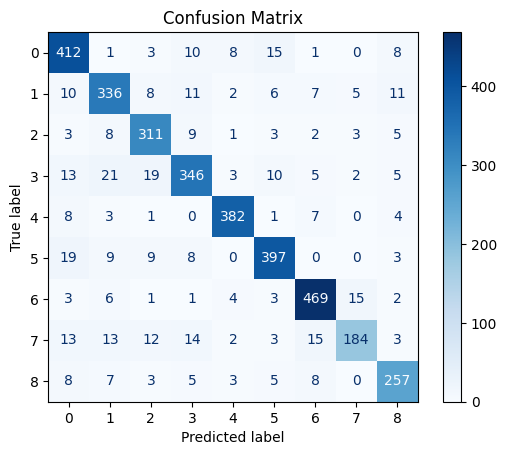


0: 384x640 1 person, 143.6ms
Speed: 1.1ms preprocess, 143.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Predicted exercise class: [2]
Confidence scores: [[    0.10502     0.10822     0.14319     0.11152     0.10192     0.11377     0.10714    0.099901     0.10931]]


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from ultralytics import YOLO
from scipy.special import softmax

model = YOLO("yolov8s-pose.pt")  # Replace with your model path if different

# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)  # Fit and transform the scaler on the entire dataset

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Function to extract keypoints and predict the exercise with confidence scores
def extract_keypoints_and_predict(image_path, model, clf, scaler):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run the model to extract keypoints
    result = model(image)
    if isinstance(result, list):
        result = result[0]  # Assuming the first element contains the keypoints

    keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # Flatten keypoints

    # Normalize the keypoints
    normalized_keypoints = scaler.transform([keypoints.flatten()])

    # Predict the exercise class using the classifier
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Apply softmax to the confidence scores
    exercise_class_proba = softmax(exercise_class_proba, axis=1)

    # Print the predicted class and confidence scores
    print(f"Predicted exercise class: {exercise_class}")
    print(f"Confidence scores: {exercise_class_proba}")

# Path to a new image (test image)
image_path = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/images/frame_1625.jpg"

# Call the function to extract keypoints and predict the exercise
extract_keypoints_and_predict(image_path, model, clf, scaler)

In [21]:
# For handling data and JSON files
import json
import numpy as np
import os

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For data normalization
from sklearn.preprocessing import MinMaxScaler

# For visualization
import matplotlib.pyplot as plt

# For pose detection
from ultralytics import YOLO

# For softmax
from scipy.special import softmax

# For counting classes
from collections import Counter


In [22]:
# Define the mapping of exercise names to labels
exercise_labels = {
    "Discurweper.json": 0,
    "Estafette.json": 1,
    "Hoogspringen.json": 2,
    "Hordenlopen.json": 3,
    "Kogelstoten.json": 4,
    "Speerwerpen.json": 5,
    "sprint_start.json": 6,
    "sprint.json": 7,
    "Verspringen.json": 8,
}

def load_keypoints(json_folder):
    X, y = [], []
    expected_num_keypoints = 17 * 2  # 17 keypoints with x, y coordinates

    for json_file, label in exercise_labels.items():
        json_path = os.path.join(json_folder, json_file)
        if not os.path.exists(json_path):
            print(f"Warning: {json_file} does not exist in {json_folder}. Skipping.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        for annotation in data["annotations"]:
            keypoints = annotation["keypoints"]
            if len(keypoints) < 51:  # 17 keypoints * 3 (x, y, visibility)
                print(f"Warning: Annotation ID {annotation['id']} in {json_file} has insufficient keypoints. Skipping.")
                continue

            # Extract x, y coordinates only and flatten
            normalized_keypoints = np.array(keypoints).reshape(-1, 3)[:, :2].flatten()

            # Pad or truncate to ensure consistent length
            if len(normalized_keypoints) < expected_num_keypoints:
                normalized_keypoints = np.pad(
                    normalized_keypoints,
                    (0, expected_num_keypoints - len(normalized_keypoints)),
                    mode="constant"
                )
            elif len(normalized_keypoints) > expected_num_keypoints:
                normalized_keypoints = normalized_keypoints[:expected_num_keypoints]

            X.append(normalized_keypoints)
            y.append(label)
    
    return np.array(X), np.array(y)

# Path to folder containing JSON files
json_folder = "/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/JsonKeypoints"
X, y = load_keypoints(json_folder)

# Verify the shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Labels array shape: {y.shape}")


Feature matrix shape: (17662, 34)
Labels array shape: (17662,)


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       458
           1       0.87      0.87      0.87       396
           2       0.92      0.94      0.93       345
           3       0.91      0.88      0.90       424
           4       0.98      0.97      0.97       406
           5       0.93      0.93      0.93       445
           6       0.94      0.94      0.94       504
           7       0.88      0.82      0.85       259
           8       0.89      0.91      0.90       296

    accuracy                           0.91      3533
   macro avg       0.91      0.91      0.91      3533
weighted avg       0.91      0.91      0.91      3533



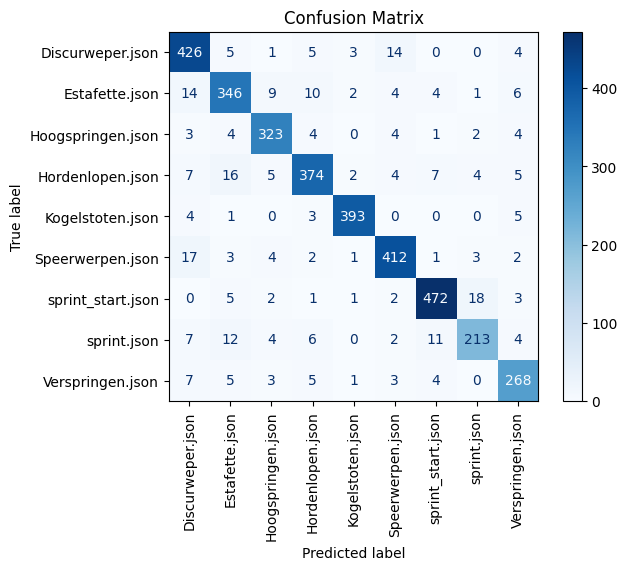

In [23]:
# Initialize the scaler
scaler = MinMaxScaler()

# Split data into training and testing sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(exercise_labels.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [24]:
# Reverse mapping of exercise labels
exercise_labels_inv = {v: k for k, v in exercise_labels.items()}


In [25]:
def extract_keypoints_and_predict(frame, model, clf, scaler):
    # Run the YOLO pose model
    results = model(frame)
    if len(results) == 0 or results[0].keypoints is None:
        return None, None  # Skip if no keypoints detected
    
    # Initialize variables to store the keypoints of the largest person
    largest_area = 0
    selected_keypoints = None

    for result in results:
        if result.keypoints is not None and result.boxes is not None and len(result.boxes) > 0:
            keypoints = result.keypoints.xy.cpu().numpy().reshape(-1, 2)  # x, y coordinates
            bbox = result.boxes.xyxy.cpu().numpy()[0]  # x_min, y_min, x_max, y_max
            x_min, y_min, x_max, y_max = bbox
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            area = bbox_width * bbox_height

            if area > largest_area:
                largest_area = area
                selected_keypoints = keypoints.flatten()

    if selected_keypoints is None:
        return None, None

    # Check if the number of keypoints matches the expected number
    expected_num_features = scaler.n_features_in_
    if selected_keypoints.size != expected_num_features:
        print(f"Expected {expected_num_features} features, but got {selected_keypoints.size} features")
        return None, None

    # Normalize keypoints
    normalized_keypoints = scaler.transform([selected_keypoints])

    # Predict class and probabilities
    exercise_class = clf.predict(normalized_keypoints)
    exercise_class_proba = clf.predict_proba(normalized_keypoints)

    # Apply softmax to the confidence scores if not already probabilities
    exercise_class_proba = softmax(exercise_class_proba, axis=1)

    return exercise_class[0], exercise_class_proba[0]


In [26]:
# Path to the video
video_path = '/Users/alessiacolumban/Desktop/TeamProject-GradindSysAthletes/Athletes/KeypointDetection/exercises/Speerwerpen/segment_000734.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
class_counts = Counter()
class_probabilities = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    try:
        exercise_class, exercise_class_proba = extract_keypoints_and_predict(frame, model, clf, scaler)
        if exercise_class is not None:
            frame_count += 1
            class_counts[exercise_class] += 1
            class_probabilities.append(exercise_class_proba)
    except ValueError as e:
        print(f"Skipping frame due to error: {e}")
        continue  # Skip problematic frames

cap.release()

# Calculate overall percentages based on frame count
class_labels = clf.classes_
total_frames = sum(class_counts.values())

if total_frames == 0:
    print("No frames were classified.")
else:
    class_percentages = {exercise_labels_inv[c]: (count / total_frames) * 100 for c, count in class_counts.items()}
    
    # Calculate average probabilities across all frames
    if class_probabilities:
        average_probabilities = np.mean(class_probabilities, axis=0)
        probability_percentages = {exercise_labels_inv[i]: p * 100 for i, p in enumerate(average_probabilities)}
    else:
        probability_percentages = {}

    # Output results
    print("Class Percentages (Based on Frame Count):")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    print("\nAverage Probabilities (Softmax Scores):")
    for cls, pct in probability_percentages.items():
        print(f"{cls}: {pct:.2f}%")



0: 384x640 2 persons, 95.5ms
Speed: 2.1ms preprocess, 95.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Expected 34 features, but got 68 features

0: 384x640 2 persons, 74.2ms
Speed: 0.6ms preprocess, 74.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Expected 34 features, but got 68 features

0: 384x640 2 persons, 73.3ms
Speed: 0.9ms preprocess, 73.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Expected 34 features, but got 68 features

0: 384x640 2 persons, 76.0ms
Speed: 0.7ms preprocess, 76.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Expected 34 features, but got 68 features

0: 384x640 1 person, 73.3ms
Speed: 0.8ms preprocess, 73.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 73.1ms
Speed: 0.8ms preprocess, 73.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 79.6ms
Speed: 0.8ms preprocess, 79.6ms inference, 

In [28]:
# Output results
print("Class Percentages (Based on Frame Count):")
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

print("\nAverage Probabilities (Softmax Scores):")
for cls, pct in probability_percentages.items():
    print(f"{cls}: {pct:.2f}%")



Class Percentages (Based on Frame Count):
Speerwerpen.json: 99.68%
Estafette.json: 0.16%
Verspringen.json: 0.16%

Average Probabilities (Softmax Scores):
Discurweper.json: 9.54%
Estafette.json: 9.45%
Hoogspringen.json: 9.41%
Hordenlopen.json: 9.40%
Kogelstoten.json: 9.42%
Speerwerpen.json: 24.39%
sprint_start.json: 9.40%
sprint.json: 9.41%
Verspringen.json: 9.57%
